# Introduction



# Load packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import time
from itertools import product
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

PATH = '../input/competitive-data-science-predict-future-sales'

/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


# Load data

In [2]:
sales_train_df = pd.read_csv(os.path.join(PATH, 'sales_train.csv'))
item_categories_df = pd.read_csv(os.path.join(PATH, 'item_categories.csv'))
items_df = pd.read_csv(os.path.join(PATH, 'items.csv'))
shops_df = pd.read_csv(os.path.join(PATH, 'shops.csv'))
test_df = pd.read_csv(os.path.join(PATH, 'test.csv'))
sample_submission_df = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))

# Data exploration

## Check the data

In [3]:
print(f"Sales train: {sales_train_df.shape}")
print(f"Item categories: {item_categories_df.shape}")
print(f"Items: {items_df.shape}")
print(f"Shops: {shops_df.shape}")
print(f"Test: {test_df.shape}")
print(f"Sample submission: {sample_submission_df.shape}")

Sales train: (2935849, 6)
Item categories: (84, 2)
Items: (22170, 3)
Shops: (60, 2)
Test: (214200, 3)
Sample submission: (214200, 2)


In [4]:
sales_train_df.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [5]:
item_categories_df.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [6]:
items_df.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [7]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [8]:
test_df.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [9]:
sample_submission_df.head(2)

,ID,item_cnt_month
0,0,0.5
1,1,0.5


## Missing data and data types

In [10]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [11]:
missing_data(sales_train_df)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
Total,0,0,0,0,0,0
Percent,0,0,0,0,0,0
Types,object,int64,int64,int64,float64,float64


In [12]:
missing_data(item_categories_df)

,item_category_name,item_category_id
Total,0,0
Percent,0,0
Types,object,int64


In [13]:
missing_data(items_df)

,item_name,item_id,item_category_id
Total,0,0,0
Percent,0,0,0
Types,object,int64,int64


In [14]:
missing_data(shops_df)

,shop_name,shop_id
Total,0,0
Percent,0,0
Types,object,int64


In [15]:
missing_data(test_df)

,ID,shop_id,item_id
Total,0,0,0
Percent,0,0,0
Types,int64,int64,int64


## Duplicate data

In [16]:
duplicate_rows_sales_train = sales_train_df[sales_train_df.duplicated(keep='last')]
duplicate_rows_sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,05.01.2013,0,54,20130,149.0,1.0
1435365,23.02.2014,13,50,3423,999.0,1.0
1496765,23.03.2014,14,21,3423,999.0,1.0
1671872,01.05.2014,16,50,3423,999.0,1.0
1866322,12.07.2014,18,25,3423,999.0,1.0
2198564,31.12.2014,23,42,21619,499.0,1.0


In [17]:
duplicate_rows_item_categories = item_categories_df[item_categories_df.duplicated(keep='last')]
print(duplicate_rows_item_categories.shape)

(0, 2)


In [18]:
duplicate_rows_items = items_df[items_df.duplicated(keep='last')]
print(duplicate_rows_items.shape)

(0, 3)


In [19]:
duplicate_rows_shops = shops_df[shops_df.duplicated(keep='last')]
print(duplicate_rows_shops.shape)

(0, 2)


In [20]:
duplicate_rows_shops = shops_df[shops_df[['shop_name']].duplicated(keep='last')]
print(duplicate_rows_shops.shape)

(0, 2)


In [21]:
duplicate_test = test_df[test_df.duplicated(keep='last')]
print(duplicate_test.shape)

(0, 3)


## Outliers data

In [22]:
sales_train_df.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


We observe that the price as well as the item count / day shows extreme values as well as negative values. 
Let's visualize their distribution and then let's remove the outliers.

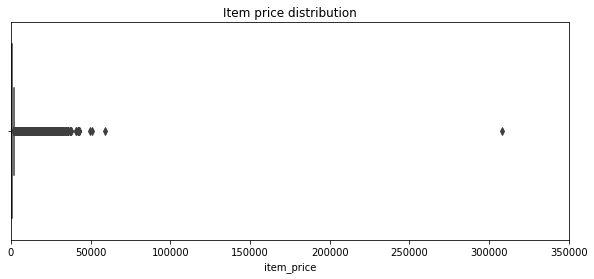

In [23]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 350000)
plt.title('Item price distribution')
sns.boxplot(x=sales_train_df.item_price)
plt.show()

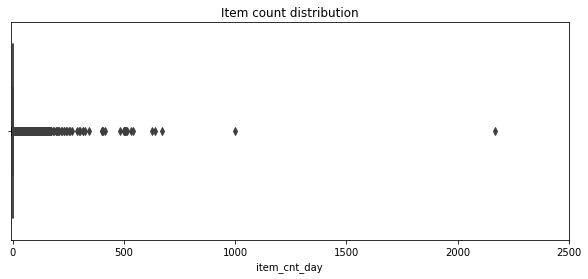

In [24]:
plt.figure(figsize=(10,4))
plt.xlim(-10, 2500)
plt.title('Item count distribution')
sns.boxplot(x=sales_train_df.item_cnt_day)
plt.show()

### Remove outliers

In [25]:
sales_train_df = sales_train_df.loc[sales_train_df.item_price < 100000]
sales_train_df = sales_train_df.loc[sales_train_df.item_cnt_day < 1001]
sales_train_df.shape

(2935847, 6)

### Replace price for shop with negative price

In [26]:
sales_train_df[sales_train_df.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [27]:
sales_train_df[(sales_train_df.date_block_num==4) & (sales_train_df.shop_id==32) & (sales_train_df.item_id==2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484683,15.05.2013,4,32,2973,-1.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


Let's replace the price of the item with negative price with the medial value of the group.

In [28]:
median_price = sales_train_df[(sales_train_df.date_block_num==4) & (sales_train_df.shop_id==32) & (sales_train_df.item_id==2973) & \
                              (sales_train_df.item_price>0)].item_price.median()
print(median_price)
sales_train_df.loc[sales_train_df.item_price < 0, 'item_price'] = median_price

1874.0


## Time variation

Let's check the number of items sold per date block. First we check that each date block starts in one of the calendaristic months.

In [29]:
min_block_day = sales_train_df.groupby(['date_block_num'])['date'].min()
min_block_day = pd.DataFrame({'date_block':min_block_day.index, 'start_date':min_block_day.values})
np.transpose(min_block_day)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
date_block,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
start_date,01.01.2013,01.02.2013,01.03.2013,01.04.2013,01.05.2013,01.06.2013,01.07.2013,01.08.2013,01.09.2013,01.10.2013,...,01.01.2015,01.02.2015,01.03.2015,01.04.2015,01.05.2015,01.06.2015,01.07.2015,01.08.2015,01.09.2015,01.10.2015


The dates are from Jan 2013 to Oct 2015, each date block corresponding to a month.

In [30]:
sales_per_day = sales_train_df.groupby(['date_block_num'])['item_cnt_day'].sum()
sales_per_day = pd.DataFrame({'date_block':sales_per_day.index, 'sales':sales_per_day.values})

In [31]:
sales_per_day.head(2)

,date_block,sales
0,0,131479.0
1,1,128090.0


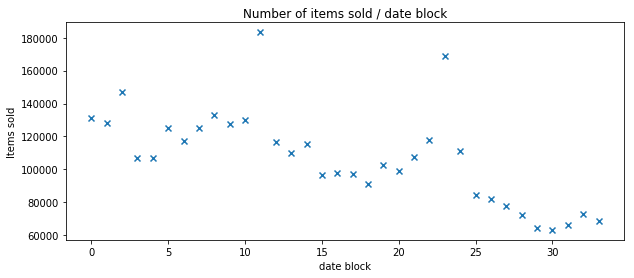

In [32]:
plt.figure(figsize=(10,4))
plt.scatter(x=sales_per_day['date_block'], y=sales_per_day['sales'], marker='x')
plt.title('Number of items sold / date block')
plt.xlabel('date block')
plt.ylabel('Items sold')
plt.show()

Let's check now the number of items sold per shop per month.

In [33]:
sales_per_month_shop = sales_train_df.groupby(['date_block_num', 'shop_id'])['item_cnt_day'].sum()
sales_per_month_shop = sales_per_month_shop.reset_index()
sales_per_month_shop.head()

,date_block_num,shop_id,item_cnt_day
0,0,0,5578.0
1,0,1,2947.0
2,0,2,1146.0
3,0,3,767.0
4,0,4,2114.0


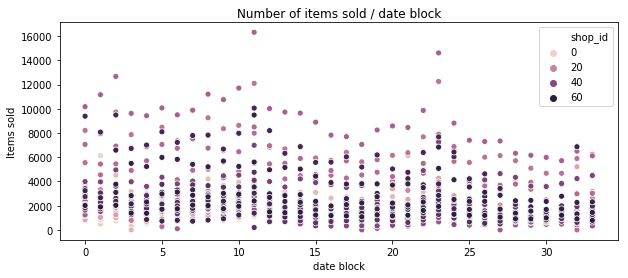

In [34]:
plt.figure(figsize=(10,4))
sns.scatterplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=sales_per_month_shop)
plt.title('Number of items sold / date block')
plt.xlabel('date block')
plt.ylabel('Items sold')
plt.show()

# Feature engineering

## Extract city name from shop name

In [35]:
shops_df.loc[shops_df.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops_df['city'] = shops_df['shop_name'].str.split(' ').map(lambda x: x[0])
shops_df.loc[shops_df.city == '!Якутск', 'city'] = 'Якутск'
shops_df['city_code'] = LabelEncoder().fit_transform(shops_df['city'])
shops_df = shops_df[['shop_id','city_code']]

Let's see how many different shops and cities are.

In [36]:
print(f"There are {shops_df.shop_id.nunique()} shops in {shops_df.city_code.nunique()} cities.")

There are 60 shops in 31 cities.


## Extract category and subcategory

In [37]:
item_categories_df['split'] = item_categories_df['item_category_name'].str.split('-')
item_categories_df['type'] =item_categories_df['split'].map(lambda x: x[0].strip())
item_categories_df['type_code'] = LabelEncoder().fit_transform(item_categories_df['type'])
# if subtype is nan then type
item_categories_df['subtype'] = item_categories_df['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories_df['subtype_code'] = LabelEncoder().fit_transform(item_categories_df['subtype'])
item_categories_df = item_categories_df[['item_category_id','type_code', 'subtype_code']]

In [38]:
items_df.drop(['item_name'], axis=1, inplace=True)

Let's see how many types and subtypes are in item categories.

In [39]:
print(f"Types {item_categories_df.type_code.nunique()}; subtypes: {item_categories_df.subtype_code.nunique()}")

Types 20; subtypes: 65


## Calculate monthly sales in train

In [40]:
print(f"Items in test not in train: {len(list(set(test_df.item_id) - set(test_df.item_id).intersection(set(sales_train_df.item_id))))}")
print(f"Items in test: {len(list(set(test_df.item_id)))}")
print(f"Test length: {len(test_df)}")

Items in test not in train: 363
Items in test: 5100
Test length: 214200


In [41]:
start_time = time.time()
all_data = []
cols = ['date_block_num','shop_id','item_id']
# for all date block numbers
for i in range(34):
    sales = sales_train_df[sales_train_df.date_block_num==i]
    all_data.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
all_data = pd.DataFrame(np.vstack(all_data), columns=cols)
all_data['date_block_num'] = all_data['date_block_num'].astype(np.int8)
all_data['shop_id'] = all_data['shop_id'].astype(np.int8)
all_data['item_id'] = all_data['item_id'].astype(np.int16)
all_data.sort_values(cols,inplace=True)
print(f"Prepare to build monthly sales: {round(time.time() - start_time, 2)} sec.")

Prepare to build monthly sales: 20.55 sec.


Calculate total revenue per shop and day (product of item price and item count / day)

In [42]:
sales_train_df['revenue'] = sales_train_df['item_price'] *  sales_train_df['item_cnt_day']

In [43]:
start_time = time.time()
monthly_group = sales_train_df.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
monthly_group.columns = ['item_cnt_month']
monthly_group.reset_index(inplace=True)

all_data = pd.merge(all_data, monthly_group, on=cols, how='left')
all_data['item_cnt_month'] = (all_data['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # target clipped here, we are not using all months segments
                                .astype(np.float16))
print(f"Compute monthly sales and clip train: {round(time.time() - start_time, 2)} sec.")

Compute monthly sales and clip train: 7.09 sec.


## Prepare test set

In [44]:
# set the date block number for test set to 34
test_df['date_block_num'] = 34
# convert integer type for the features in test set
test_df['date_block_num'] = test_df['date_block_num'].astype(np.int8)
test_df['shop_id'] = test_df['shop_id'].astype(np.int8)
test_df['item_id'] = test_df['item_id'].astype(np.int16)

## Concatenate train and test

In [45]:
start_time = time.time()
all_data = pd.concat([all_data, test_df], ignore_index=True, sort=False, keys=cols)
all_data.fillna(0, inplace=True) # 34 month (fill with 0)
print(f"Merge train and test: {round(time.time() - start_time, 2)} sec.")

Merge train and test: 0.32 sec.


## Merge with shops, items and items category

In [46]:
start_time = time.time()
# merge with shops
all_data = pd.merge(all_data, shops_df, on=['shop_id'], how='left')
# merge with items
all_data = pd.merge(all_data, items_df, on=['item_id'], how='left')
# merge with item categories
all_data = pd.merge(all_data, item_categories_df, on=['item_category_id'], how='left')
# change data types
all_data['city_code'] = all_data['city_code'].astype(np.int8)
all_data['item_category_id'] = all_data['item_category_id'].astype(np.int8)
all_data['type_code'] = all_data['type_code'].astype(np.int8)
all_data['subtype_code'] = all_data['subtype_code'].astype(np.int8)
print(f"Merge with shows, items and items category: {round(time.time() - start_time, 2)} sec.")

Merge with shows, items and items category: 6.56 sec.


## Target lag features

In [47]:
def build_lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [48]:
start_time = time.time()
all_data = build_lag_feature(all_data, [1,2,3,6,12], 'item_cnt_month')
print(f"Calculate target lag features: {round(time.time() - start_time, 2)} sec.")

Calculate target lag features: 45.1 sec.


## Mean encoded features

In [49]:
start_time = time.time()
# group-by count / month - aggregate - mean
month_cnt_group = all_data.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
month_cnt_group.columns = [ 'date_avg_item_cnt']
month_cnt_group.reset_index(inplace=True)
# merge new feature
all_data = pd.merge(all_data, month_cnt_group, on=['date_block_num'], how='left')
all_data['date_avg_item_cnt'] = all_data['date_avg_item_cnt'].astype(np.float16)
all_data = build_lag_feature(all_data, [1], 'date_avg_item_cnt')
all_data.drop(['date_avg_item_cnt'], axis=1, inplace=True)
print(f"Calculate mean encoded cnt/month: {round(time.time() - start_time, 2)} sec.")

Calculate mean encoded cnt/month: 14.35 sec.


In [50]:
start_time = time.time()
# group-by count / month - aggregate - mean
group = all_data.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num','item_id'], how='left')
all_data['date_item_avg_item_cnt'] = all_data['date_item_avg_item_cnt'].astype(np.float16)
all_data = build_lag_feature(all_data, [1,2,3,6,12], 'date_item_avg_item_cnt')
all_data.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
print(f"Calculate mean encoded cnt/month: {round(time.time() - start_time, 2)} sec.")

Calculate mean encoded cnt/month: 53.8 sec.


In [51]:
start_time = time.time()
group = all_data.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num','item_category_id'], how='left')
all_data['date_cat_avg_item_cnt'] = all_data['date_cat_avg_item_cnt'].astype(np.float16)
all_data = build_lag_feature(all_data, [1], 'date_cat_avg_item_cnt')
all_data.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
print(f"Calculate mean encoded cnt/month/item category: {round(time.time() - start_time, 2)} sec.")

Calculate mean encoded cnt/month/item category: 17.46 sec.


In [52]:
start_time = time.time()
group = all_data.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
all_data['date_shop_cat_avg_item_cnt'] = all_data['date_shop_cat_avg_item_cnt'].astype(np.float16)
all_data = build_lag_feature(all_data, [1], 'date_shop_cat_avg_item_cnt')
all_data.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
print(f"Calculate mean encoded cnt/month/item category: {round(time.time() - start_time, 2)} sec.")

Calculate mean encoded cnt/month/item category: 18.58 sec.


## Few special features

In [53]:
all_data['month'] = all_data['date_block_num'] % 12

In [54]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data['days'] = all_data['month'].map(days).astype(np.int8)

## Prepare for the model

In [55]:
start_time = time.time()
all_data = all_data[all_data.date_block_num > 11]
print(f"Filter train data: {round(time.time() - start_time, 2)} sec.")

Filter train data: 0.75 sec.


Eliminate the NAs.

In [56]:
start_time = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

all_data = fill_na(all_data)
print(f"Fill NA with zeros: {round(time.time() - start_time, 2)} sec.")

Fill NA with zeros: 1.38 sec.


In [57]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'city_code', 'item_category_id', 'type_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'month', 'days'],
      dtype='object')

In [58]:
all_data = all_data[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'city_code', 'item_category_id', 'type_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'month', 'days']]

In [59]:
X_train = all_data[all_data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = all_data[all_data.date_block_num < 33]['item_cnt_month']
X_valid = all_data[all_data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data[all_data.date_block_num == 33]['item_cnt_month']
X_test = all_data[all_data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

# Models

Let's start with Random Forest.

## Random Forest

In [60]:
model_rf = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=4,
    max_depth=8, 
    n_jobs = -1)

In [61]:
start_time = time.time()

model_rf.fit(
    X_train, 
    Y_train)

print(f"Fit RF the model: {round(time.time() - start_time, 2)} sec.")

Fit RF the model: 1679.33 sec.


In [62]:
Y_pred = model_rf.predict(X_valid).clip(0, 20)
Y_test = model_rf.predict(X_test).clip(0, 20)

submission_rf = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": Y_test
})
submission_rf.to_csv('submission_rf.csv', index=False)

## XGBoost 

In [63]:
model_xgb = XGBRegressor(
    max_depth=8,
    n_estimators=100,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

In [64]:
start_time = time.time()

model_xgb.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 3)

print(f"Fit the model: {round(time.time() - start_time, 2)} sec.")

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[23:16:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:16:51] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12637	validation_1-rmse:1.12159
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 3 rounds.
[1]	validation_0-rmse:1.09423	validation_1-rmse:1.09244
[2]	validation_0-rmse:1.06317	validation_1-rmse:1.06578
[3]	validation_0-rmse:1.02669	validation_1-rmse:1.04343
[4]	validation_0-rmse:0.999896	validation_1-rmse:1.0243
[5]	validation_0-rmse:0.977599	validation_1-rmse:1.00889
[6]	validation_0-rmse:0.960847	validation_1-rmse:0.996341
[7]	validation_0-rmse:0.942342	validation_1-rmse:0.984003
[8]	validation_0-rmse:0.928936	validation_1-rmse

In [65]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

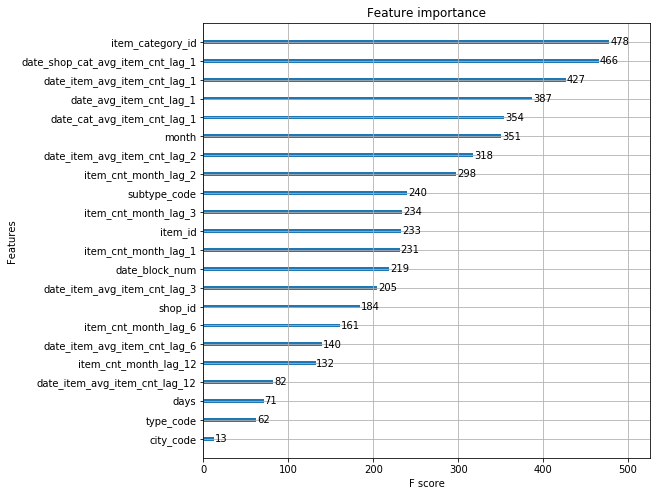

In [66]:
plot_features(model_xgb, (8,8))

In [67]:
Y_pred = model_xgb.predict(X_valid).clip(0, 20)
Y_test = model_xgb.predict(X_test).clip(0, 20)

submission_xgb = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": Y_test
})
submission_xgb.to_csv('submission_xgb.csv', index=False)

# Average model

Let's use a simple blending, by averaging the result of the two models.

In [68]:
submission_avg = submission_rf
submission_avg['item_cnt_month'] = submission_rf['item_cnt_month'] * 0.4 + submission_xgb['item_cnt_month'] * 0.6
submission_avg.to_csv('submission_avg.csv', index=False)